# **This notebook will be used for model definition, training and evaluation**

**Let's first import some relevant packages**

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import types
import pandas as pd
import sklearn
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Let's now retrieve the dataset which we worked on in the previous notebook**

In [2]:
# retrieve features 
link = 'https://drive.google.com/file/d/12L3tz73CXMzdkx3HwFaTJk6UHg0J1u-z/view?usp=sharing'
fluff, id  = link.split('d/')
id, fluff = id.split('/view')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('x2---post feature_eng.csv')  
x = pd.read_csv('x2---post feature_eng.csv')
x= x.drop(columns=["Unnamed: 0"])
x.head()
print(x.shape)

12L3tz73CXMzdkx3HwFaTJk6UHg0J1u-z
(1139267, 769)


In [3]:
# retrieve class labels
link = 'https://drive.google.com/file/d/1wZ_Vy5YXrCW0wDBIEe72U5nyDeGg7wjZ/view?usp=sharing'
fluff, id  = link.split('d/')
id, fluff = id.split('/view')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('y2---post feature_eng.csv')  
y = pd.read_csv('y2---post feature_eng.csv')
y= y.drop(columns=["Unnamed: 0"])
print(y.shape)
y.head()
y=y.values

1wZ_Vy5YXrCW0wDBIEe72U5nyDeGg7wjZ
(1139267, 1)


In [4]:
# Mount google drive for upload later
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


**Let's define some functions which will help us later**

In [5]:
from keras.callbacks import History 
history = History()



# this will plot the loss and accuracy over epochs
def makegraphs():
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_figwidth(15)
  fig.tight_layout(pad=5.0)
  ax1.plot(hist.history['accuracy'])
  ax1.plot(hist.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_ylim(0,1) 
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'test'], loc='upper left')
  ax2.plot(hist.history['loss'])
  ax2.plot(hist.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'test'], loc='upper left')



# This will turn decimal outputs into binary outputs (positive or negative class)
def binarise():
  
  global tr_predict
  global ts_predict
 
  tr_predict = pd.DataFrame(tr_predict)
  tr_predict[tr_predict <= 0.5] = 0.
  tr_predict[tr_predict > 0.5] = 1.

  ts_predict = pd.DataFrame(ts_predict)
  ts_predict[ts_predict <= 0.5] = 0.
  ts_predict[ts_predict > 0.5] = 1.


from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt  



# this will display relevant metrics
def showmetrics(ytr,rw):

  global results
  global tr_predict
  global ts_predict


  print("Train Acc: " , accuracy_score(ytr, tr_predict))
  print("Test Acc: " , accuracy_score(y_test, ts_predict))
  print("")

  cm = confusion_matrix(y_test, ts_predict)

  tn = cm.ravel()[0]
  fp = cm.ravel()[1]
  fn = cm.ravel()[2]
  tp = cm.ravel()[3]
  
   
  fig, (ax) = plt.subplots(1, 1)
  sns.heatmap(cm, annot=True, fmt = ".0f", ax = ax,cmap="Blues"); #annot=True to annotate cells
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

  sens = tp/(tp+fn)
  recall=sens
  spec = tn/(fp+tn)
  fprate = fp/(fp+tn)
  prec = tp/(tp+fp)

  f1 = 2/((1/prec)+(1/recall))
  f2= (1+2**2)*(prec*recall)/(2**2*prec + recall)
  fhalf= (1+0.5**2)*(prec*recall)/(0.5**2*prec + recall)

  print("True Positive Rate (Sensitivity a.k.a Recall): ", sens)
  print("True Negative Rate (Specificity): ", spec)
  print("False Positive Rate: ", fprate)
  print("Precision: ", prec )
  print("F1: harmonic mean of precision and recall", f1)
  print("F2 (weighted to recall - false negative more costly): ", f2)
  print("F0.5 (weighted to precision - false positives more costly): ", fhalf)
  print("")

  if rw > results.shape[0]:
    results = results.append(pd.Series(), ignore_index=True)
  results.loc[rw-1:rw-1,'Model':'Test F0.5'] = modelname, accuracy_score(ytr, tr_predict), accuracy_score(y_test, ts_predict), tn, fp, fn, tp, sens, spec, fprate, prec, f1, f2, fhalf
  
  del tr_predict
  del ts_predict

  display(results)



# this will save files to google drive and overwrite if they already exist
def uploadfile():

  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  file_list = drive.ListFile({'q':"'1EeZCwYgPr_nntYAYrNNhOrA7Hf0PRJ2p'  in parents and trashed=False"}).GetList()
  
  filefound = 0

  for x in range(len(file_list)):
    if file_list[x]['title'] == filename:
      ident = file_list[x]['id']
      filefound = 1

  if filefound==1:
    file1 = drive.CreateFile({'id':ident,'title' : filename, 'parents': [{'id': '1EeZCwYgPr_nntYAYrNNhOrA7Hf0PRJ2p'}]})
  else:
    file1 = drive.CreateFile({'title' : filename, 'parents': [{'id': '1EeZCwYgPr_nntYAYrNNhOrA7Hf0PRJ2p'}]})
  file1.SetContentFile(filename)
  file1.Upload()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Let's conduct Principal Component Analysis on the features to reduce dimensions down from 769 to 256. We will use the Incremental PCA package to do the processing in batches, to save memory**

In [6]:
from sklearn.decomposition import IncrementalPCA
from sklearn.externals import joblib

print(x.shape)

ipca = IncrementalPCA(n_components=256, batch_size=10000)
x_ipca = ipca.fit_transform(x)

print(ipca.explained_variance_ratio_)
print(sum(ipca.explained_variance_ratio_))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


(1139267, 769)
[0.05144331 0.04345462 0.04237608 0.04025779 0.03787199 0.03633267
 0.03499152 0.02808216 0.0204078  0.01989215 0.01575248 0.0156699
 0.01469314 0.01378836 0.0130592  0.01255018 0.01201391 0.01195191
 0.01151378 0.00982933 0.00963343 0.009568   0.00951411 0.00914295
 0.00899704 0.00864398 0.00779059 0.0074608  0.0074461  0.00725937
 0.00700727 0.00696053 0.00683397 0.00650432 0.00648503 0.00635387
 0.00626235 0.00618509 0.00613269 0.00600313 0.00598132 0.0059573
 0.00587659 0.00570722 0.00547948 0.00546403 0.00539294 0.0053399
 0.0051507  0.00512354 0.00499185 0.00483832 0.00478758 0.00462677
 0.00461031 0.00446112 0.00436702 0.00420654 0.00411139 0.00388708
 0.00387296 0.00386471 0.00377984 0.00368611 0.00363457 0.00358946
 0.00354764 0.00347707 0.00338162 0.00325066 0.00321271 0.00313083
 0.00306572 0.00302349 0.00300494 0.00287171 0.00283936 0.0026665
 0.00260297 0.00258008 0.00255866 0.00254174 0.0025116  0.00246943
 0.00245321 0.00240786 0.00237412 0.00235047 0.0023

**96% of the variance of the original 768 dimensions can be explained using this set of 256, so this is a good approximation of the original dataset. Let's now save the transformer so we can use it to pre-process unseen data during model deployment**

In [0]:
# Save the ipca transformer for use in deployment
filename = "ipca.pkl"
joblib.dump(ipca, filename)
uploadfile()

**Let's now retrieve the class labels and split into train and test data**

In [8]:
# split into train and test data

msk = np.random.rand(len(x)) < 0.8
x_ipca_train = x_ipca[msk]  
x_ipca_test = x_ipca[~msk]
y_train = y[msk]
y_test = y[~msk]

del msk
del x_ipca
del y
del x

print(x_ipca_train.shape) 
print(x_ipca_test.shape) 
print(y_train.shape) 
print(y_test.shape) 

(911660, 256)
(227607, 256)
(911660, 1)
(227607, 1)


**Let's first use a dummy classifier to use as a benchmark to compare other classifiers**

##### **DUMMY CLASSIFER**

---

Train Acc:  0.8382390364828993
Test Acc:  0.8396138958819368

True Positive Rate (Sensitivity a.k.a Recall):  0.0
True Negative Rate (Specificity):  1.0
False Positive Rate:  0.0
Precision:  nan
F1: harmonic mean of precision and recall nan
F2 (weighted to recall - false negative more costly):  nan
F0.5 (weighted to precision - false positives more costly):  nan



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN


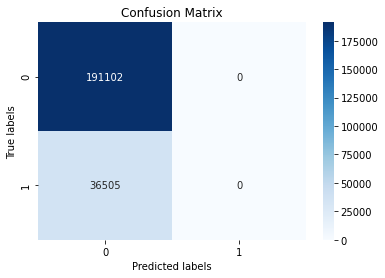

In [9]:
from sklearn.dummy import DummyClassifier

results = pd.DataFrame(columns = ['Model','Train Accuracy','Test Accuracy','Test True Negative','Test False Positive','Test False Negative','Test True Positive','Test Sensitivity a.k.a Recall','Test Specificity','Test False Positive Rate','Test Precision','Test F1','Test F2','Test F0.5'])

DC =  DummyClassifier(strategy="most_frequent")
DC.fit(x_ipca_train, y_train)

# make predictions
tr_predict = DC.predict(x_ipca_train)
ts_predict = DC.predict(x_ipca_test)

# show metrics
modelname = "Dummy Classifier"
showmetrics(y_train,1)

# Save the model
filename = modelname + ".pkl"
joblib.dump(DC, filename)
uploadfile()


**It's predicting all negatives, as this is the  most common in the train data. Let's now try a logistic classifier**

##### **LOGISTIC REGRESSION**

---

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train Acc:  0.9246714784020359
Test Acc:  0.9249232229237238

True Positive Rate (Sensitivity a.k.a Recall):  0.7442268182440761
True Negative Rate (Specificity):  0.9594405082102752
False Positive Rate:  0.04055949178972486
Precision:  0.7780291531830809
F1: harmonic mean of precision and recall 0.760752688172043
F2 (weighted to recall - false negative more costly):  0.7507502528476449
F0.5 (weighted to precision - false positives more costly):  0.7710252524392528



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025


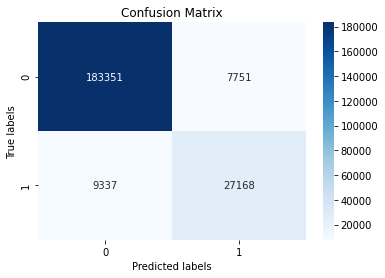

In [10]:
from sklearn.linear_model import LogisticRegression


# define and fit model
log1 = LogisticRegression(random_state=0, max_iter = 10)
log1.fit(x_ipca_train, y_train)

# make predictions
tr_predict = log1.predict(x_ipca_train)
ts_predict = log1.predict(x_ipca_test)

# convert output to binary
binarise()

# show metrics
modelname = "Logistic Classifier"
showmetrics(y_train,2)

# Save the model
filename = modelname + ".pkl"
joblib.dump(log1, filename)
uploadfile()

**This performs better. Let's try a decision tree classifier now**

##### **DECISION TREE CLASSIFIER**

Train Acc:  0.9240681833139548
Test Acc:  0.9243872112896352

True Positive Rate (Sensitivity a.k.a Recall):  0.738337214080263
True Negative Rate (Specificity):  0.9599271593180605
False Positive Rate:  0.04007284068193949
Precision:  0.7787408627315016
F1: harmonic mean of precision and recall 0.7580010124303954
F2 (weighted to recall - false negative more costly):  0.7460790229805514
F0.5 (weighted to precision - false positives more costly):  0.7703102046882233



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031


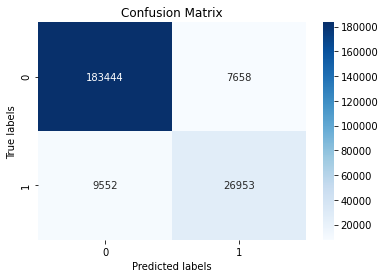

In [11]:
from sklearn.tree import DecisionTreeClassifier 

# define and fit model
DTC = DecisionTreeClassifier(max_depth = 3)
DTC.fit(x_ipca_train, y_train)

# make predictions
tr_predict = DTC.predict(x_ipca_train)
ts_predict = DTC.predict(x_ipca_test)

# show metrics
modelname = "Decision Tree"
showmetrics(y_train,3)

# Save the model
filename = modelname + ".pkl"
joblib.dump(log1, filename)
uploadfile()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


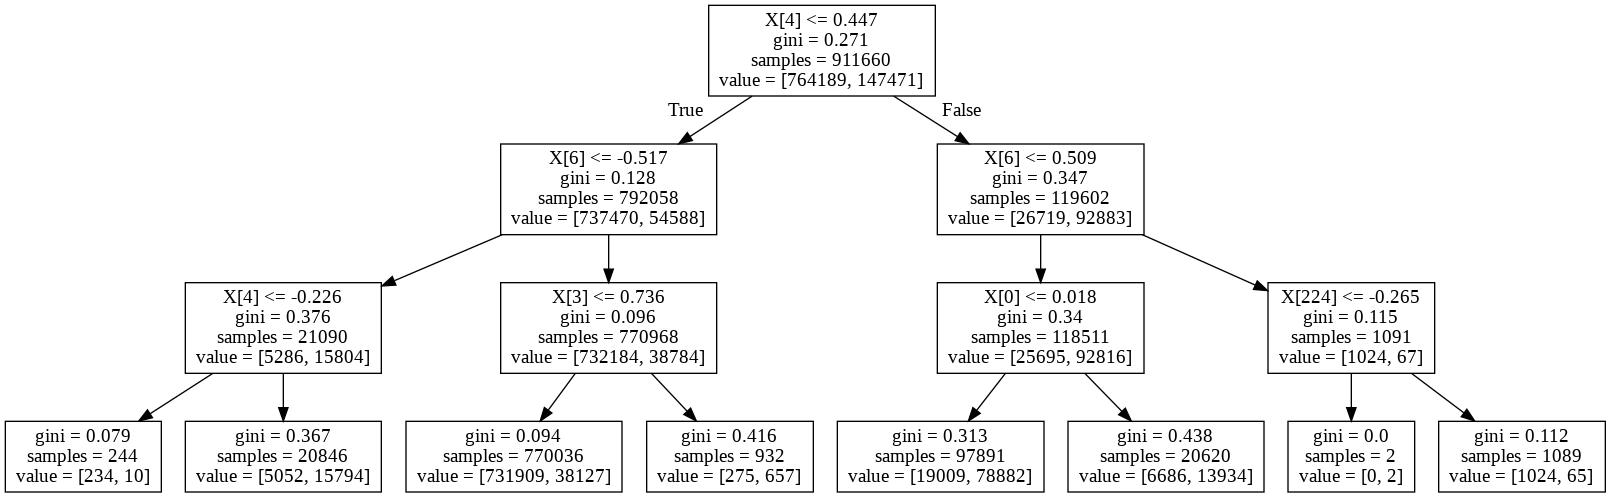

In [12]:
# plot tree
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image 
dot_data = StringIO()
from sklearn import tree

tree.export_graphviz(DTC, max_depth = 3, out_file= dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('tree.png')
Image(graph.create_png())

**Let's now try a deep feed-forward neural network**

##### **DEEP FEED FORWARD NEURAL NETWORK 1**

---

Train Acc:  0.9266316389882193
Test Acc:  0.9236095550664083

True Positive Rate (Sensitivity a.k.a Recall):  0.7204766470346528
True Negative Rate (Specificity):  0.9624127429330933
False Positive Rate:  0.03758725706690668
Precision:  0.7854796320630749
F1: harmonic mean of precision and recall 0.751575247538899
F2 (weighted to recall - false negative more costly):  0.7326020590070417
F0.5 (weighted to precision - false positives more costly):  0.7715573130878135



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557


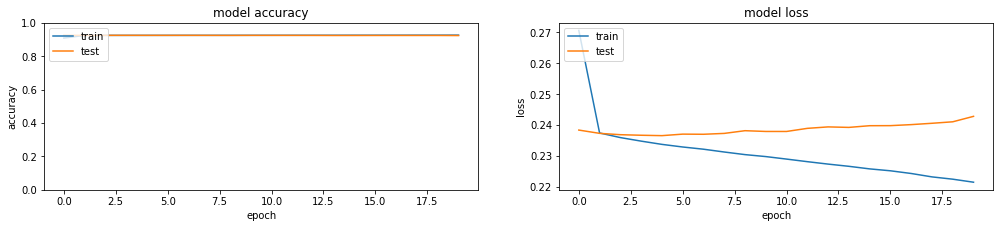

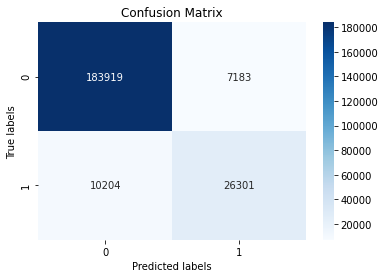

In [13]:
# define the neural network for classifying the flight data

import keras as keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Dense, Dropout


model1 = keras.Sequential()
model1.add(layers.Dense(256, activation="relu"))
model1.add(layers.Dense(512, activation="relu"))
model1.add(layers.Dense(1,activation="sigmoid"))

# Compile the network
model1.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

# Train the neural network
hist = model1.fit(x_ipca_train,y_train, epochs = 20, batch_size= 5000, shuffle=True, validation_data=(x_ipca_test,y_test), verbose = 0)

# plot loss and accuracy 
makegraphs()

# make predictions
tr_predict = model1.predict(x_ipca_train, batch_size=200000)
ts_predict = model1.predict(x_ipca_test, batch_size=200000)

# convert sigmoid output to binary
binarise ()

# show metrics
modelname = "Deep Feed-Forward NN 1"
showmetrics(y_train,4)

#save model
filename = modelname + ".h5"
model1.save(filename)
uploadfile()

**Let's set the initial output bias at the log of the ratio of positives/negatives, to try and combat the imbalanced data with much more negatives. We will also add more fully-connected layers and some dropout layers and see if this improves the model**

##### **DEEP FEED FORWARD NEURAL NETWORK 2**

---

In [14]:
from keras import initializers

pos = y_train.mean()
neg = 1-pos
print(pos)
print(neg)
output_bias = np.log([pos/neg])
output_bias = keras.initializers.Constant(output_bias)

0.16176096351710068
0.8382390364828993


Train Acc:  0.9253844635061317
Test Acc:  0.9245102303531966

True Positive Rate (Sensitivity a.k.a Recall):  0.7283933707711272
True Negative Rate (Specificity):  0.9619731870938033
False Positive Rate:  0.038026812906196694
Precision:  0.7853619635525888
F1: harmonic mean of precision and recall 0.7558056905716154
F2 (weighted to recall - false negative more costly):  0.7391161738298949
F0.5 (weighted to precision - false positives more costly):  0.7732663304892022



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266


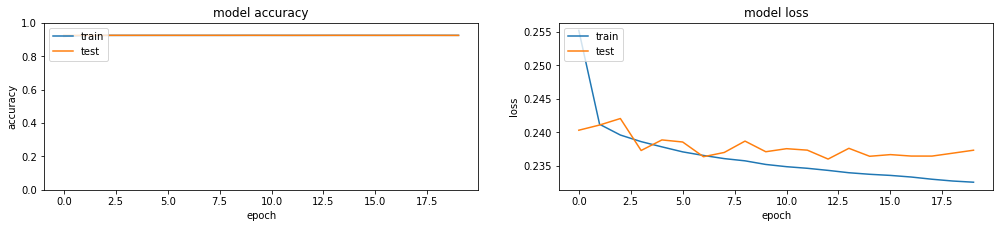

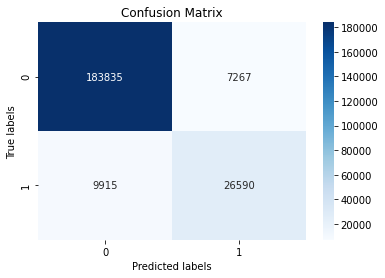

In [15]:
model2 = keras.Sequential()
model2.add(layers.Dense(256, activation="relu"))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation="relu"))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation="relu"))
model2.add(layers.Dense(1,activation="sigmoid", bias_initializer=output_bias))

# Compile the network
model2.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

# Train the neural network
hist = model2.fit(x_ipca_train,y_train, epochs = 20, batch_size= 5000, shuffle=True, validation_data=(x_ipca_test,y_test), verbose = 0)

# plot loss and accuracy 
makegraphs()

# make predictions
tr_predict = model2.predict(x_ipca_train, batch_size=200000)
ts_predict = model2.predict(x_ipca_test, batch_size=200000)

# convert sigmoid output to binary
binarise()

# show metrics
modelname = "Deep Feed-Forward NN 2"
showmetrics(y_train,5)

#save model
filename = modelname + ".h5"
model2.save(filename)
uploadfile()

**This didn't make much difference. Let's try resampling the training data to see if that improves the model. In this case let's use oversampling to duplicate positives to get a near 50:50 distribution of positives and negatives**

##### **DEEP FEED FORWARD NEURAL NETWORK 3**

---

In [16]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
x_ipca_train_ov, y_train_ov = oversample.fit_resample(x_ipca_train, y_train)
print(x_ipca_train_ov.shape) 
print(y_train_ov.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(1528378, 256)
(1528378,)


Train Acc:  0.8598088954434047
Test Acc:  0.9141546613241245

True Positive Rate (Sensitivity a.k.a Recall):  0.7582249006985344
True Negative Rate (Specificity):  0.9439409320676916
False Positive Rate:  0.0560590679323084
Precision:  0.7209574911439883
F1: harmonic mean of precision and recall 0.7391217271719828
F2 (weighted to recall - false negative more costly):  0.7504663470923801
F0.5 (weighted to precision - false positives more costly):  0.728114987399578



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115


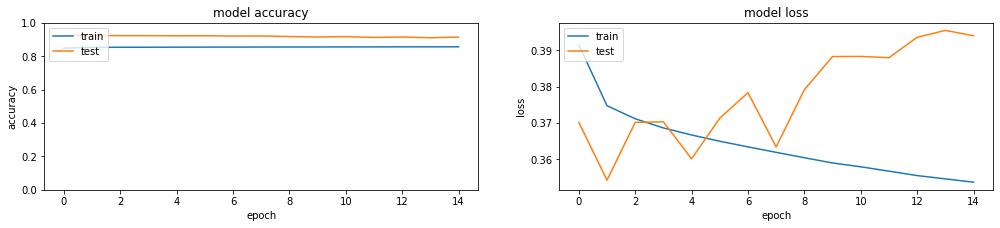

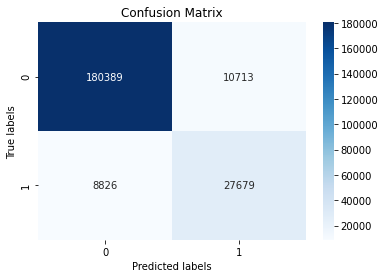

In [17]:
# Define the model 

model_ov = keras.Sequential()
model_ov.add(layers.Dense(256, activation="relu"))
model_ov.add(layers.Dropout(0.5))
model_ov.add(layers.Dense(512, activation="relu"))
model_ov.add(layers.Dropout(0.5))
model_ov.add(layers.Dense(512, activation="relu"))
model_ov.add(layers.Dense(1,activation="sigmoid"))

# Compile the model
model_ov.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

# Train the model
hist = model_ov.fit(x_ipca_train_ov,y_train_ov, epochs = 15, batch_size= 5000, shuffle=True, validation_data=(x_ipca_test,y_test), verbose = 0)

# plot loss and accuracy 
makegraphs()

# make predictions
tr_predict = model_ov.predict(x_ipca_train_ov, batch_size=200000)
ts_predict = model_ov.predict(x_ipca_test, batch_size=200000)

# convert sigmoid output to binary
binarise()

# show metrics
modelname = "Deep Feed-Forward NN 3 (Ov)"
showmetrics(y_train_ov,6)

#save model
filename = modelname + ".h5"
model_ov.save(filename)
uploadfile()

**Not much difference in the train performance. Let's try undersampling**

##### **DEEP FEED FORWARD NEURAL NETWORK 4**

---

In [18]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
x_ipca_train_un, y_train_un = undersample.fit_resample(x_ipca_train, y_train)
print(x_ipca_train_un.shape) 
print(y_train_un.shape)

(294942, 256)
(294942, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Acc:  0.8538017644146985
Test Acc:  0.923512897230753

True Positive Rate (Sensitivity a.k.a Recall):  0.7469113820024654
True Negative Rate (Specificity):  0.9572479618214357
False Positive Rate:  0.04275203817856433
Precision:  0.7694435037814652
F1: harmonic mean of precision and recall 0.7580100360017237
F2 (weighted to recall - false negative more costly):  0.7513116127325633
F0.5 (weighted to precision - false positives more costly):  0.7648289751976168



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829


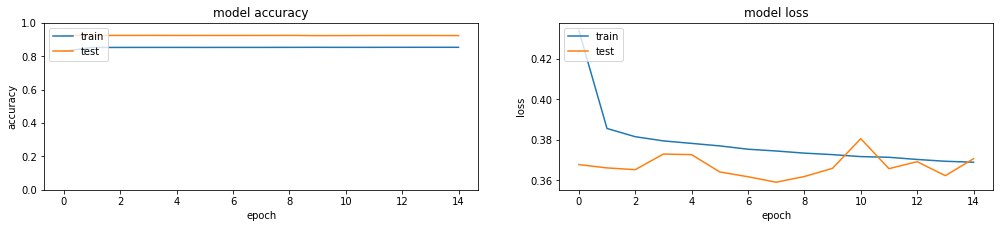

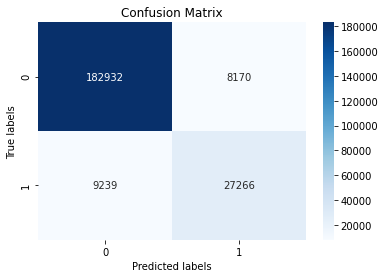

In [19]:
# Define the model 

model_un = keras.Sequential()
model_un.add(layers.Dense(256, activation="relu"))
model_un.add(layers.Dropout(0.5))
model_un.add(layers.Dense(512, activation="relu"))
model_un.add(layers.Dropout(0.5))
model_un.add(layers.Dense(512, activation="relu"))
model_un.add(layers.Dense(1,activation="sigmoid"))

# Compile the model
model_un.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

# Train the model
hist = model_un.fit(x_ipca_train_un,y_train_un, epochs = 15, batch_size= 5000, shuffle=True, validation_data=(x_ipca_test,y_test), verbose = 0)

# plot loss and accuracy 
makegraphs()

# make predictions
tr_predict = model_un.predict(x_ipca_train_un, batch_size=200000)
ts_predict = model_un.predict(x_ipca_test, batch_size=200000)

# convert sigmoid output to binary
binarise()

# show metrics
modelname = "Deep Feed-Forward NN 4 (Un)"
showmetrics(y_train_un,7)

#save model
filename = modelname + ".h5"
model_un.save(filename)
uploadfile()

**Not much difference. Let's try a random forest classifier and see if this improves the model performance**

##### **RANDOM FOREST CLASSIFIER 1**

---

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Train Acc:  0.9881611565715288
Test Acc:  0.9077137346390928

True Positive Rate (Sensitivity a.k.a Recall):  0.6128201616216956
True Negative Rate (Specificity):  0.9640453789075991
False Positive Rate:  0.03595462109240092
Precision:  0.7650297517269681
F1: harmonic mean of precision and recall 0.6805177422543995
F2 (weighted to recall - false negative more costly):  0.638215928153279
F0.5 (weighted to precision - false positives more costly):  0.7288252656819114



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825


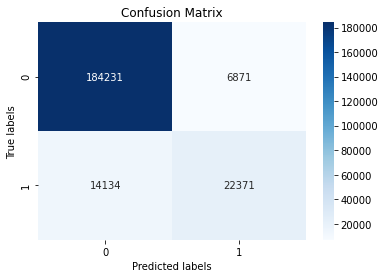

In [20]:
from sklearn.ensemble import RandomForestClassifier

# define and fit model
RFC1 = RandomForestClassifier(verbose=1,class_weight = 'balanced', n_estimators = 10)
RFC1.fit(x_ipca_train, y_train)

# make predictions
tr_predict = RFC1.predict(x_ipca_train)
ts_predict = RFC1.predict(x_ipca_test)

# show metrics
modelname = "Random Forest Classifier 1"
showmetrics(y_train,8)

# save model
filename = modelname + ".pkl"
joblib.dump(RFC1, filename)
uploadfile()

**This does much better on the train data, but less well on the test data, suggesting overfit. Let's try setting the class weights to see if that makes a difference (penalise errors on the positives more than the negatives)**

##### **RANDOM FOREST CLASSIFIER 2**

---

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


Train Acc:  0.9879637145427024
Test Acc:  0.9079949210700902

True Positive Rate (Sensitivity a.k.a Recall):  0.6133954252842077
True Negative Rate (Specificity):  0.9642703896348547
False Positive Rate:  0.03572961036514531
Precision:  0.7663244353182751
F1: harmonic mean of precision and recall 0.6813845568657284
F2 (weighted to recall - false negative more costly):  0.6388952293996805
F0.5 (weighted to precision - false positives more costly):  0.7299279590572741



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825
8,Random Forest Classifier 2,0.987964,0.907995,184274,6828,14113,22392,0.613395,0.96427,0.0357296,0.766324,0.681385,0.638895,0.729928


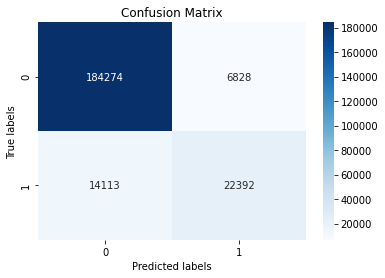

In [21]:
# define and fit model
RFC2 = RandomForestClassifier(verbose=1,class_weight={0:1,1:5}, n_estimators = 10)
RFC2.fit(x_ipca_train, y_train)

# make predictions
tr_predict = RFC2.predict(x_ipca_train)
ts_predict = RFC2.predict(x_ipca_test)

# show metrics
modelname = "Random Forest Classifier 2"
showmetrics(y_train,9)

# save model
filename = modelname + ".pkl"
joblib.dump(RFC2, filename)
uploadfile()

**About the same, but let's try the oversampled train data with a roughly even number of positives and negatives**

##### **RANDOM FOREST CLASSIFIER 3**

---

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


Train Acc:  0.9986240314895922
Test Acc:  0.9025073921276586

True Positive Rate (Sensitivity a.k.a Recall):  0.6694973291329955
True Negative Rate (Specificity):  0.9470178229427217
False Positive Rate:  0.05298217705727831
Precision:  0.7070736293938955
F1: harmonic mean of precision and recall 0.6877726185450964
F2 (weighted to recall - false negative more costly):  0.6766896475344021
F0.5 (weighted to precision - false positives more costly):  0.6992246731324921



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825
8,Random Forest Classifier 2,0.987964,0.907995,184274,6828,14113,22392,0.613395,0.96427,0.0357296,0.766324,0.681385,0.638895,0.729928
9,Random Forest Classifier 3 (Ov),0.998624,0.902507,180977,10125,12065,24440,0.669497,0.947018,0.0529822,0.707074,0.687773,0.67669,0.699225


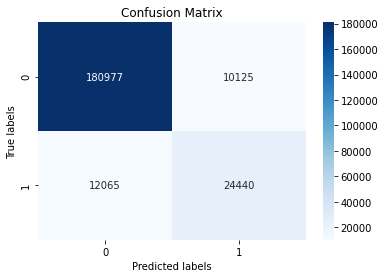

In [22]:
# define and fit model
RFC3 = RandomForestClassifier(verbose=1,class_weight = 'balanced', n_estimators = 10)
RFC3.fit(x_ipca_train_ov, y_train_ov)

# make predictions
tr_predict = RFC3.predict(x_ipca_train_ov)
ts_predict = RFC3.predict(x_ipca_test)

# show metrics
modelname = "Random Forest Classifier 3 (Ov)"
showmetrics(y_train_ov,10)

# save model
filename = modelname + ".pkl"
joblib.dump(RFC3, filename)
uploadfile()

**Very similar results. Let's try the undersampled data**

##### **RANDOM FOREST CLASSIFIER 4**

---

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Train Acc:  0.9822778715815312
Test Acc:  0.8621659263555163

True Positive Rate (Sensitivity a.k.a Recall):  0.7677030543761129
True Negative Rate (Specificity):  0.8802105681782504
False Positive Rate:  0.11978943182174964
Precision:  0.5504055619930475
F1: harmonic mean of precision and recall 0.6411429617258814
F2 (weighted to recall - false negative more costly):  0.7115219587990067
F0.5 (weighted to precision - false positives more costly):  0.5834336082740357



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825
8,Random Forest Classifier 2,0.987964,0.907995,184274,6828,14113,22392,0.613395,0.96427,0.0357296,0.766324,0.681385,0.638895,0.729928
9,Random Forest Classifier 3 (Ov),0.998624,0.902507,180977,10125,12065,24440,0.669497,0.947018,0.0529822,0.707074,0.687773,0.67669,0.699225


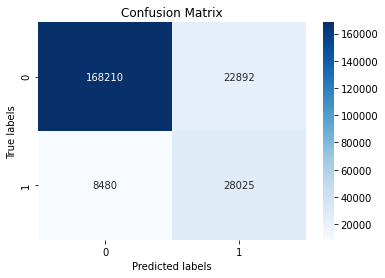

In [23]:
# define and fit model
RFC4 = RandomForestClassifier(verbose=0,class_weight = 'balanced', n_estimators = 10)
RFC4.fit(x_ipca_train_un, y_train_un)

# make predictions
tr_predict = RFC4.predict(x_ipca_train_un)
ts_predict = RFC4.predict(x_ipca_test)

# show metrics
modelname = "Random Forest Classifier 4 (Un)"
showmetrics(y_train_un,11)

# save model
filename = modelname + ".pkl"
joblib.dump(RFC4, filename)
uploadfile()

**This actually made the model perform worse on the test data. Let's try an eXtreme Gradient Boosting model and see if we can do better**

##### **XGBOOST 1**

---

**We will set the scale_pos_weight parameter to the square root of the ratios of negative to positive for optimal initialisation**

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Acc:  0.9244828115744905
Test Acc:  0.9247079395624915

True Positive Rate (Sensitivity a.k.a Recall):  0.7417887960553349
True Negative Rate (Specificity):  0.9596498205146989
False Positive Rate:  0.04035017948530104
Precision:  0.7783558493820063
F1: harmonic mean of precision and recall 0.7596325127989341
F2 (weighted to recall - false negative more costly):  0.7488247331452906
F0.5 (weighted to precision - false positives more costly):  0.7707568383001735



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825
8,Random Forest Classifier 2,0.987964,0.907995,184274,6828,14113,22392,0.613395,0.96427,0.0357296,0.766324,0.681385,0.638895,0.729928
9,Random Forest Classifier 3 (Ov),0.998624,0.902507,180977,10125,12065,24440,0.669497,0.947018,0.0529822,0.707074,0.687773,0.67669,0.699225


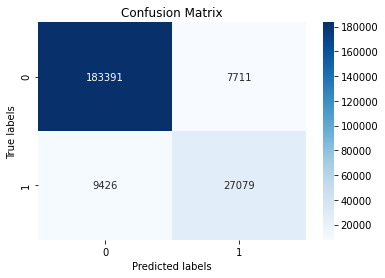

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from numpy import mean,sqrt

# define model
XGB1 = XGBClassifier(scale_pos_weight = sqrt(neg/pos))

# fit model
XGB1.fit(x_ipca_train,y_train)

# make predictions
tr_predict = XGB1.predict(x_ipca_train)
ts_predict = XGB1.predict(x_ipca_test)

# show metrics
modelname = "eXtreme Gradient Boost Classifier 1"
showmetrics(y_train,12)

# save model
filename = modelname + ".pkl"
joblib.dump(XGB1, filename)
uploadfile()

**Quite good results, but let's try the oversampled data and see if this improves the model**

##### **XGBOOST 2**

---

Train Acc:  0.8524075850345922
Test Acc:  0.9247914167841939

True Positive Rate (Sensitivity a.k.a Recall):  0.7426653883029722
True Negative Rate (Specificity):  0.9595817940157613
False Positive Rate:  0.040418205984238786
Precision:  0.7782689823453424
F1: harmonic mean of precision and recall 0.7600504625735913
F2 (weighted to recall - false negative more costly):  0.7495230986149125
F0.5 (weighted to precision - false positives more costly):  0.7708777616651028



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825
8,Random Forest Classifier 2,0.987964,0.907995,184274,6828,14113,22392,0.613395,0.96427,0.0357296,0.766324,0.681385,0.638895,0.729928
9,Random Forest Classifier 3 (Ov),0.998624,0.902507,180977,10125,12065,24440,0.669497,0.947018,0.0529822,0.707074,0.687773,0.67669,0.699225


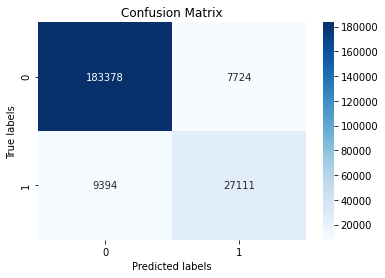

In [25]:
# define model
XGB2 = XGBClassifier()

# fit model
XGB2.fit(x_ipca_train_ov,y_train_ov)

# make predictions
tr_predict = XGB2.predict(x_ipca_train_ov)
ts_predict = XGB2.predict(x_ipca_test)

# show metrics
modelname = "eXtreme Gradient Boost Classifier 2 (Ov)"
showmetrics(y_train_ov,13)

# save model
filename = modelname + ".pkl"
joblib.dump(XGB2, filename)
uploadfile()

**A very small improvement, so let's try the undersampled data**

##### **XGBOOST 3**

---

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Acc:  0.8521336398342725
Test Acc:  0.9248002038601625

True Positive Rate (Sensitivity a.k.a Recall):  0.7426379947952335
True Negative Rate (Specificity):  0.959597492438593
False Positive Rate:  0.040402507561406995
Precision:  0.7783296488760013
F1: harmonic mean of precision and recall 0.7600650442974094
F2 (weighted to recall - false negative more costly):  0.7495120292395397
F0.5 (weighted to precision - false positives more costly):  0.7709194728969624



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,Model,Train Accuracy,Test Accuracy,Test True Negative,Test False Positive,Test False Negative,Test True Positive,Test Sensitivity a.k.a Recall,Test Specificity,Test False Positive Rate,Test Precision,Test F1,Test F2,Test F0.5
0,Dummy Classifier,0.838239,0.839614,191102,0,36505,0,0,1,0,NaN,NaN,NaN,NaN
1,Logistic Classifier,0.924671,0.924923,183351,7751,9337,27168,0.744227,0.959441,0.0405595,0.778029,0.760753,0.75075,0.771025
2,Decision Tree,0.924068,0.924387,183444,7658,9552,26953,0.738337,0.959927,0.0400728,0.778741,0.758001,0.746079,0.77031
3,Deep Feed-Forward NN 1,0.926632,0.92361,183919,7183,10204,26301,0.720477,0.962413,0.0375873,0.78548,0.751575,0.732602,0.771557
4,Deep Feed-Forward NN 2,0.925384,0.92451,183835,7267,9915,26590,0.728393,0.961973,0.0380268,0.785362,0.755806,0.739116,0.773266
5,Deep Feed-Forward NN 3 (Ov),0.859809,0.914155,180389,10713,8826,27679,0.758225,0.943941,0.0560591,0.720957,0.739122,0.750466,0.728115
6,Deep Feed-Forward NN 4 (Un),0.853802,0.923513,182932,8170,9239,27266,0.746911,0.957248,0.042752,0.769444,0.75801,0.751312,0.764829
7,Random Forest Classifier 1,0.988161,0.907714,184231,6871,14134,22371,0.61282,0.964045,0.0359546,0.76503,0.680518,0.638216,0.728825
8,Random Forest Classifier 2,0.987964,0.907995,184274,6828,14113,22392,0.613395,0.96427,0.0357296,0.766324,0.681385,0.638895,0.729928
9,Random Forest Classifier 3 (Ov),0.998624,0.902507,180977,10125,12065,24440,0.669497,0.947018,0.0529822,0.707074,0.687773,0.67669,0.699225


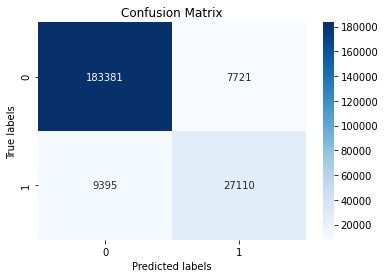

In [26]:
# define model
XGB3 = XGBClassifier()

# fit model
XGB3.fit(x_ipca_train_un,y_train_un)

# make predictions
tr_predict = XGB3.predict(x_ipca_train_un)
ts_predict = XGB3.predict(x_ipca_test)

# show metrics
modelname = "eXtreme Gradient Boost Classifier 3 (Un)"
showmetrics(y_train_un,14)

# save model
filename = modelname + ".pkl"
joblib.dump(XGB3, filename)
uploadfile()

**Very similar results, so let's upload the results to google drive for later**

In [27]:
# upload a summary of the results to google drive
results.to_csv('/drive/My Drive/Colab Notebooks/Advanced Data Science/Binary Classifier (v1)/results.csv')
print("done")

done
